In [26]:
################################################################################
## Test code for primal-dual IP                                               ##
################################################################################
using JuMP
using Ipopt
using Plots
using LinearAlgebra
using LaTeXStrings
using BenchmarkTools
pyplot()

Plots.PyPlotBackend()

In [27]:
## Update Newton direction
function update_newton_dir(c::Vector{Float64}, A::Matrix{Float64}, b::Vector{Float64},
                           x::Vector{Float64}, u::Vector{Float64}, v::Vector{Float64},
                           μ::Float64)
    ## Diagonalize u and x
    U = Diagonal(u)
    X = Diagonal(x)

    ## Calculate parmeters
    e = ones(length(x))
    (m,n) = size(A)

    ## Update Newton direction
    Nmatrix = [A zeros(m,m) zeros(m,n);
           zeros(n,n) A' Diagonal(ones(n));
           U zeros(n,m) X]

    rp = A*x .- b
    rd = A'v .+ u .- c
    rc = X*U*e - μ*e

    Nrhs = -[rp; rd; rc]
    d = Nmatrix \ Nrhs

    dₓ = d[1:n]
    dᵥ = d[n+1:n+m]
    dᵤ = d[n+m+1:end]
    return (dᵥ,dᵤ,dₓ)
end

function calculate_step_size(x::Vector{Float64}, d::Vector{Float64}, ϵ::Float64)
    n = length(d)
    α = 0.9999
    for i=1:n
        if d[i] < 0
            α = min(α, -x[i]/d[i]) # prevents variable becoming negative
        end
    end
    return round(α, digits=Int(-log10(ϵ))) #rounding avoids numerical issues
end


function primal_dual_ip(A::Matrix{Float64}, b::Vector{Float64}, c::Vector{Float64},
                        x_given::Vector{Float64}, μ::Float64, β::Float64, ϵ::Float64, N::Int)

################################################################################
## Solve the LP problem and its dual                                          ##
##                                                                            ##
## minimize    cᵀx          maximize    bᵀv                                   ##
## subject to  Ax = b       subject to  Aᵀv + u = c                           ##
##              x ≥ 0                         u ≥ 0                           ##
##                                                                            ##
################################################################################

    n = length(c)    # Number of primal variables x and dual variables u
    m = length(b)    # Number of dual variables v
    x = zeros(N, n)  # Primal variable x values
    u = zeros(N, n)  # Dual variable u values
    v = zeros(N, m)  # Dual variable v values
    e = ones(n)      # Vector of ones
    α_p = 1          # Step size for variable x update
    α_d = 1          # Step size for variable u, and v update

    ## Find an initial solution
    x₀ = [x_given;  b[1] - A[1,1:2]'x_given; b[2] - A[2,1:2]'x_given]'

    u₀ = μ ./ x₀

    u[1,:] = u₀
    x[1,:] = x₀ # Note v₀ initialised as 0

    ## Main loop
    for i = 1:N
        ## Stopping condition #1
        if n*μ < ϵ            ## if dot(c,x[i,:]) - dot(b,v[i,:]) < ϵ
            v = v[1:i,:]
            u = u[1:i,:]
            x = x[1:i,:]
            return (v,u,x)
        end
        ## Update dₓ, dᵥ, dᵤ
        (dᵥ,dᵤ,dₓ) = update_newton_dir(c,A,b,x[i,:],u[i,:],v[i,:],μ)

        ## Calculate step size α primal and α dual
        α_p = calculate_step_size(x[i,:], dₓ, ϵ)
        α_d = calculate_step_size(u[i,:], dᵤ, ϵ)

        ## Update variables
        v[i+1,:] = v[i,:] + α_d*dᵥ
        u[i+1,:] = u[i,:] + α_d*dᵤ
        x[i+1,:] = x[i,:] + α_p*dₓ

        ## Stopping condition #2
        if i == N-1
            return (v,u,x)
        end
        ## Update μ
        μ = μ*β
    end
end


## For validating the optimal solution
function linprog(c, A, b)

    m,n = size(A)

    lp = Model()
    set_optimizer(lp, Ipopt.Optimizer)   # Ipopt is a professional IPM implementation
#     set_silent(lp)                       # Removes any logging 
#     set_optimizer_attributes(lp, "mehrotra_algorithm" => "yes");
    
    @variable(lp, x[1:n])
    @constraint(lp, cons, A*x .== b)
    @constraint(lp, bound, x .>= 0)
    @objective(lp, Min, sum(c[i]*x[i] for i=1:n))

    optimize!(lp)

    return value.(x)
    #return (value.(x), dual.(bound), dual.(cons))
end;

In [33]:
## Problem in canonical form (notice that it's a 2D problem)
c = [2.0, 2.0, 0.0, 0.0]
b = [-8.0; -10.0 ]
A = [-2.0  -1.0 1.0 0.0 ;
     -1.0  -2.0 0.0 1.0 ]

## Executions and plotting
N = 500     # Number of iterations
β = 0.5     # Reduction factor
μ = 10.0    # Around 5 for efficiency.
ϵ = 1e-3    # Tolerance
x_start = [8.0, 4.0]

## Comparing solution time and the solution itself
@time (v,u,x) = primal_dual_ip(A, b, c, x_start, μ, β, ϵ, N)
x_opt = linprog(c, A, b);

  0.000196 seconds (956 allocations: 144.562 KiB)
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

In [29]:
@show norm(x[end, 1:2] - x_opt[1:2]); #if the solutions are the same, this should be zero! 

norm(x[end, 1:2] - x_opt[1:2]) = 0.00021579480692860377


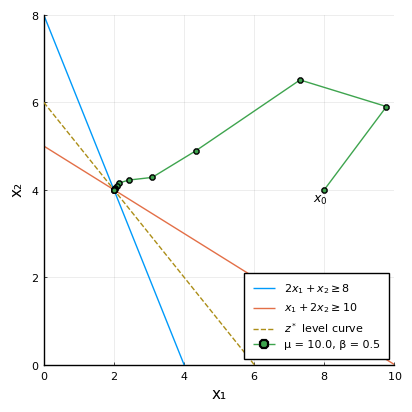

In [34]:
## Plotting...
x1 = range(0, 15, length=100)
x2 = range(0, 15, length=100)

plot(x1, 8 .- 2*x1, color = :1, label = L"$2x_1 + x_2 \geq 8$", legend=:bottomright)
plot!(x1, (10 .- x1)./2, color = :2, label = L"$x_1 + 2x_2 \geq 10$",
xaxis = ("x₁", (0,10)),
yaxis = ("x₂", (0,8)),
# aspect_ratio = :equal,
size = (400,400),
#legend = false
#title = L"$\rho = 5, \beta = 0.5$"
)

# Objective function opt/ level curve
#z* = 12 // y = 6 - x1
plot!(x1, 6 .- x1, color = :5, line = :dash, label = L"$z^*$ level curve")

traj = x[1:end,1:2]
plot!(traj[:,1], traj[:,2], marker = :o, color = :3, label = "μ = $(μ), β = $(β)")
annotate!([(x_start[1]-0.1, x_start[2]-0.1, text(L"$x_0$",9,:top))])

savefig("lp_example1-1.pdf")

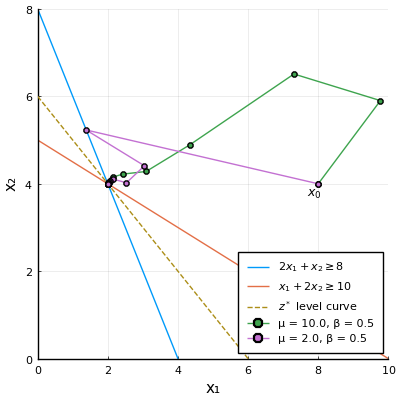

  0.000362 seconds (779 allocations: 125.031 KiB)


In [35]:
β = 0.5     # Reduction factor
μ = 2.0     # Around 5 for efficiency.
ϵ = 1e-3    # Tolerance

## Comparing solution time and the solution itself
@time (v,u,x) = primal_dual_ip(A, b, c, x_start, μ, β, ϵ, N)

traj = x[1:end,1:2]
display(plot!(traj[:,1], traj[:,2], marker = :o, color = :4, label="μ = $(μ), β = $(β)"))

savefig("lp_example1-2.pdf")